# Plot sam_planck

In [1]:
# %load first_cell.py
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"


def print_shape(*args):
    nelem = len(args)
    for ii in range(nelem - 1):
        print(args[ii].shape, end=" ")
    print(args[nelem - 1].shape)


def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder


path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

DEBUG:jupyter_black:Using config from /home/jchaves/Proyectos/projects/lya/cup1d/pyproject.toml
DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

/home/jchaves/Proyectos/projects/lya/cup1d/notebooks/


## Read Data

### Options

In [2]:
from cup1d.scripts.call_max_like_sim import Args
from cup1d.scripts.max_like_sim import fname_minimize
from cup1d.scripts.sam_like_sim import path_sampler
from matplotlib.ticker import MaxNLocator
from lace.archive import gadget_archive, nyx_archive
from cup1d.likelihood import lya_theory
from lace.cosmo.camb_cosmo import (
    get_camb_results,
    get_Nyx_cosmology,
    get_cosmology_from_dictionary,
)
from lace.cosmo.fit_linP import parameterize_cosmology_kms
from cup1d.likelihood import CAMB_model

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [3]:
from chainconsumer import ChainConsumer, Chain, Truth, PlotConfig
import pandas as pd

#### load planck

In [68]:
par_names = ["$A_s/A^\mathrm{fid}_s-1$", "$n_s/n^\mathrm{fid}_s-1$"]

In [78]:
fnames = "/home/jchaves/Proyectos/projects/lya/data/planck/COM_CosmoParams_base-plikHM-TTTEEE-lowl-lowE_R3.00/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE.paramnames"
_ = np.loadtxt(fnames, dtype="str")
planck_names = _[:, 0]
planck_names_descr = _[:, 1]

dict_plack = {"w": [], par_names[0]: [], par_names[1]: []}
fchain = "/home/jchaves/Proyectos/projects/lya/data/planck/COM_CosmoParams_base-plikHM-TTTEEE-lowl-lowE_R3.00/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_"
for ii in range(1, 5):
    file = np.loadtxt(fchain + str(ii) + ".txt")
    dict_plack["w"].append(file[:, 0])
    #     dict_plack["lnprop"].append(file[:, 1])
    dict_plack[par_names[0]].append(np.exp(file[:, 6]) / 1e10)
    dict_plack[par_names[1]].append(file[:, 7])
for par in dict_plack:
    dict_plack[par] = np.concatenate(dict_plack[par])

dict_plack[par_names[0]] = (
    dict_plack[par_names[0]] / np.median(dict_plack[par_names[0]]) - 1
)
dict_plack[par_names[1]] = (
    dict_plack[par_names[1]] / np.median(dict_plack[par_names[1]]) - 1
)

#### load cabayol23

In [7]:
fchain_cabayol = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/Cabayol23_lres/Cabayol23_Chabanier2019_mpg_central_igm2_ydrop_ypoly/chain_1_extended/chain.npy"
chain_cabayol = np.load(fchain_cabayol)
fsum_cabayol = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/Cabayol23_lres/Cabayol23_Chabanier2019_mpg_central_igm2_ydrop_ypoly/chain_1_extended/results.npy"
sum_cabayol = np.load(fsum_cabayol, allow_pickle=True).item()

dict_cabayol23 = {
    "$\Delta A_s$": chain_cabayol[:, 0] - sum_cabayol["truth"]["$A_s$"],
    "$\Delta n_s$": chain_cabayol[:, 1] - sum_cabayol["truth"]["$n_s$"],
}

### load nyx

In [79]:
fchain_nyx = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/Nyx23_Oct2023_lres/Nyx_v0_Chabanier2019_nyx_central_igm2_ydrop_ypoly/chain_1_extended/chain.npy"
chain_nyx = np.load(fchain_nyx)
fsum_nyx = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/Nyx23_Oct2023_lres/Nyx_v0_Chabanier2019_nyx_central_igm2_ydrop_ypoly/chain_1_extended/results.npy"
sum_nyx = np.load(fsum_nyx, allow_pickle=True).item()

# dict_nyx23 = {
#     "$\Delta A_s$": chain_nyx[:, 0] - sum_nyx["truth"]["$A_s$"],
#     "$\Delta n_s$": chain_nyx[:, 1] - sum_nyx["truth"]["$n_s$"],
# }

dict_nyx23 = {
    par_names[0]: chain_nyx[:, 0] / np.median(chain_nyx[:, 0]) - 1,
    par_names[1]: chain_nyx[:, 1] / np.median(chain_nyx[:, 1]) - 1,
}

In [80]:
fchain_nyx = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/Nyx23_Oct2023_lres/Nyx_v0_QMLE_Ohio_nyx_central_igm2_ydrop_ypoly/chain_1/chain.npy"
chain_nyx = np.load(fchain_nyx)
fsum_nyx = "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/Nyx23_Oct2023_lres/Nyx_v0_QMLE_Ohio_nyx_central_igm2_ydrop_ypoly/chain_1/results.npy"
sum_nyx = np.load(fsum_nyx, allow_pickle=True).item()

# dict_nyx23b = {
#     "$\Delta A_s$": chain_nyx[:, 0] - sum_nyx["truth"]["$A_s$"],
#     "$\Delta n_s$": chain_nyx[:, 1] - sum_nyx["truth"]["$n_s$"],
# }


dict_nyx23b = {
    par_names[0]: chain_nyx[:, 0] / np.median(chain_nyx[:, 0]) - 1,
    par_names[1]: chain_nyx[:, 1] / np.median(chain_nyx[:, 1]) - 1,
}

## plot

In [81]:
c = ChainConsumer()

In [82]:
pd_planck = pd.DataFrame(data=dict_plack)
chain = Chain(samples=pd_planck, weight_column="w", name="Planck")
c.add_chain(chain)

In [11]:
pd_mpg = pd.DataFrame(data=dict_cabayol23)
chain = Chain(samples=pd_mpg, name="LaCE mpg")
c.add_chain(chain)

In [83]:
pd_nyx = pd.DataFrame(data=dict_nyx23)
chain = Chain(samples=pd_nyx, name="Emulator eBOSS")
c.add_chain(chain)

pd_nyx = pd.DataFrame(data=dict_nyx23b)
chain = Chain(samples=pd_nyx, name="Emulator DESI")
c.add_chain(chain)

In [84]:
c.add_truth(
    Truth(
        location={
            par_names[0]: 0,
            par_names[1]: 0,
        },
        line_style=":",
        color="black",
    )
)

In [85]:
c.set_plot_config(
    PlotConfig(
        extents={
            par_names[0]: (-0.25, 0.25),
            par_names[1]: (-0.025, 0.025),
        }
    )
)

<IPython.core.display.Javascript object>


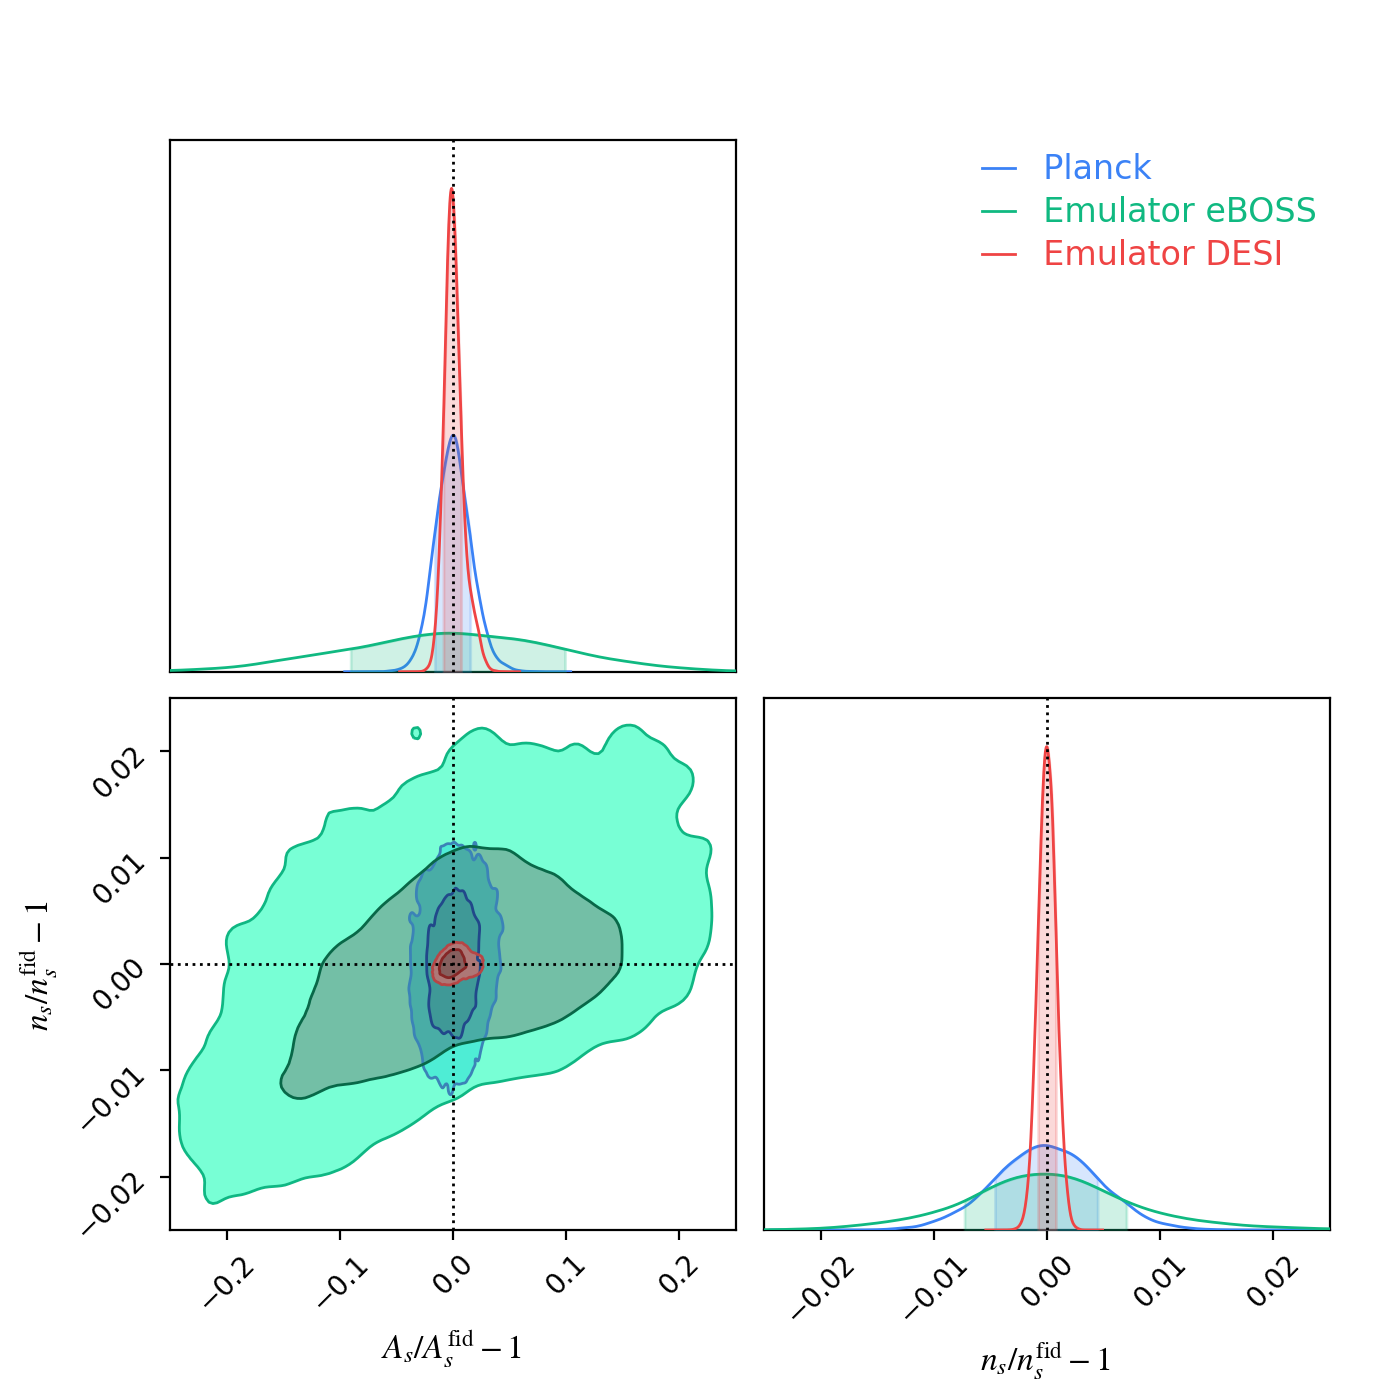

In [86]:
fig = c.plotter.plot()

In [87]:
fig.savefig(
    "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/fig/compare_central.pdf"
)
fig.savefig(
    "/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler/fig/compare_central.png"
)